<a href="https://colab.research.google.com/github/Booss3my/Ganimals/blob/main/Ganimals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training a generative model on a very small Dataset using autoencoding
In this small project, i've given myself the challenge to train a DC-GAN using sprites from one of the best Pokemon games: Black 2 (in my opinion :) ).

The main limitation that pops up is the size of the available data (~<1000 4x96x96 images).



Data augmentation is possible, but keeping in mind the result we hope to obtain at the output of the generative model, which is high quality sprites, consistant with the style and quality of the original data we eliminate some of the augmentation methods such as  scaling, cropping, padding, changing brightness, contrast ... For now we'll keep Data Augmentation aside as it affects the quality of the generation.

The second idea I had is to compress this Data to a very small scale, then use it to train an accordingly small generative model.


We'll proceed by training the autoencoder first then combining the generative model and the autoencoder (the autoencoder parameters will be kept constant for the first cycles, once the generator is able to generate acceptable quality images we'll train the model as whole)  








**Imports**

In [2]:
from google.colab import files
from google.colab import drive
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torch.autograd import Variable

**Dataset upload (Pokemeon Black and White game sprites ~<1000 images ) + extraction**


The images contain different Pokemons on a blank background (RGB+apha channels) with different aspect Ratios.

**Autoencoding:**
Autoencoding is a generalization to the Principle Component Analysis (PCA) algorithm (to non-linear manifolds with help of non-linear activation functions). 

**Small recap on dimentionality reduction:** We project our data to a lower dimension subsbace while trying to keep most the information, in PCA we make basis out of the k eigenvectors corresponding the k greatest eigenvalues of the covariance matrix of the data.
(***Fast demo:*** The quantity of information contained in the data is measured by entropy, and the differential entropy of the data distribution (modeled as a Gaussian distribution) is proportional to the log determinant of the covariance matrix ($Σ=\mathbb{E}[(X-\mathbb{E}(X))(X-\mathbb{E}(X))^T])$ ) with an additive constant depending on the number of samples ($H(\Sigma)=\frac{N}{2}+\frac{N log(2\pi)}{2}+ \frac{log(det(Σ))}{2}$ with $N$ the number of samples) . Thus, the quantity of information is related to the sum of the log of the eigenvalues of the data convolution matrix ($det(\Sigma)=\prod_{\lambda \in A} \lambda$ with $A$ the set of eigenvalues of $\Sigma$).
Thus, the subspace of dimension k that maximises entropy is constructed by taking the k eigenvectors corresponding the k greatest eigenvalues of $Σ$).


**(To do)** 
**Different aspect ratios problem** ( smaller pokemons are more difficult to compress, less information in the image -> ) 

In [44]:
# 2 Mo dataset :)
uploaded = files.upload()

Saving black-white.zip to black-white.zip


In [45]:
%mkdir data
%mkdir data/extracted
dir="data/black-white" #preprocessed images
save_dir="data/extracted" #processed images 
with zipfile.ZipFile('black-white.zip', 'r') as zip_ref:
    zip_ref.extractall("data")

%rm black-white.zip


mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/extracted’: File exists


**Preprocessing functions**

In [46]:
def to_gray(img): #ccomvert to grayscale
  image=transforms.transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.ToTensor()])(img)
  return(image)


def bbox_find(img):  #finds a bounding box (using the alpha channel but can be done by hand since the dataset is very small )
  img=transforms.ToTensor()(img)  #2d input(alpha channel)
  line=torch.zeros(img.shape[1])
  col=torch.zeros(img.shape[2])

  i,a,x,y,w,h=0,0,0,0,0,0

  while i<img.shape[1] and a==0:
    a=1
    if torch.equal(img[0,i,:],line):
      y=i
      a=0
    i=i+1 
    if torch.equal(img[0,-i-1,:],line):
      a=0
      h=img.shape[1]-2*i 
    i=i+1 

  a,i=0,0
  while i<img.shape[2] and a==0:
    a=1
    if torch.equal(img[0,:,i],col):
      x=i
      a=0
    if torch.equal(img[0,:,-i-1],col):
      a=0
      w=img.shape[2]-2*i
    i=i+1 

  return(x,y,w+min(img.shape[2]-(y+h),6),h+min(img.shape[1]-(x+w),6))


def crop(image): #crops image to bbox
  [x,y,w,h]=bbox_find(image[:,:,3])
  #print("old bbox", y,y+h,x,x+w)
  tmp=max(w,h)
  #print("new bbox", y-(tmp-h)//2,y+(tmp+h)//2,x-(tmp-w)//2,x+(tmp+w)//2)
  img=image[max(y-(tmp-h)//2,0):min(y+(tmp+h)//2,image.shape[1]),max(x-(tmp-w)//2,0):min(x+(tmp+w)//2,image.shape[0]),:]

  return(img)

def upsamp(img,size):
  #np array input of h,w,c=4
  #finds bounding box then upsample the image to a size
  img=crop(img)
  img=transforms.ToTensor()(img)
  ups=nn.Upsample(size=(size, size), mode='bilinear')
  tmp=ups(img.view(1,4,img.shape[1],img.shape[2]))
  img = tmp.reshape(4,size,size)
  img = img.permute(1, 2, 0)
  img = img.detach().numpy()
  return img

**Apply preprocessing to all images then save them in a new folder**

In [47]:
files_=os.listdir(dir)

for path in files_:
  if os.path.isfile(dir+"/"+path):
    im=upsamp(plt.imread(dir+"/"+path),size)
    plt.imsave(save_dir+"/"+path,im)

shutil.rmtree(dir)
dir=save_dir 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


68
40
130
687


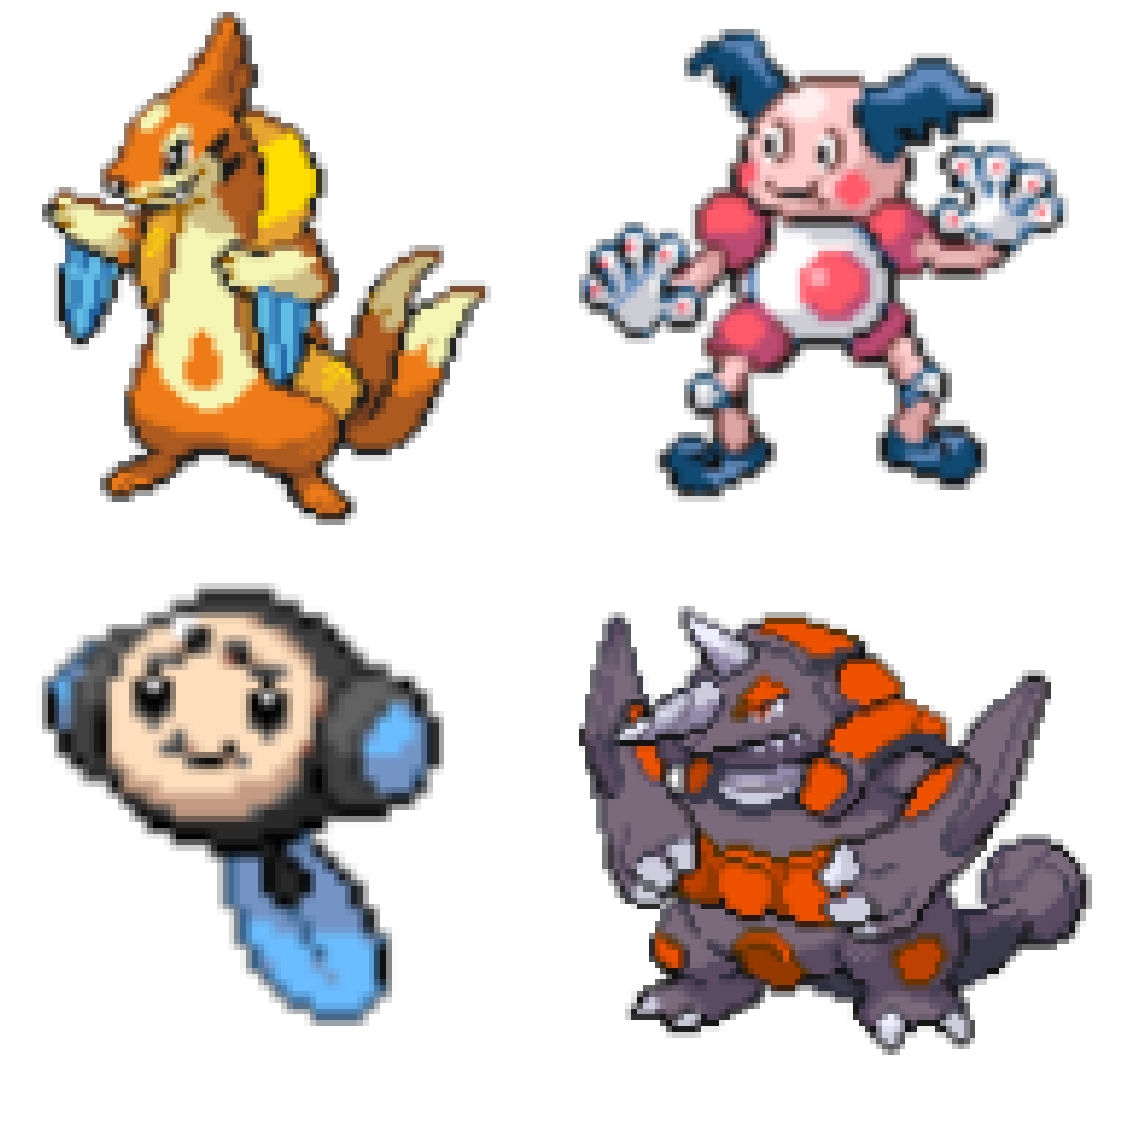

In [48]:
#test
files_=os.listdir(dir)
size=96
n = 2
rows=2
n_samples=n*rows
size=96
f, axs = plt.subplots(rows, n, figsize=(16, 16))

for j in range(n):
  for i in range(rows):
    idx=random.randint(0,len(files_))
    print(idx)
    image_path=os.path.join(dir,files_[idx])
    im=io.imread(image_path)
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
    
plt.tight_layout();


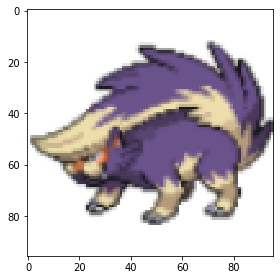

In [35]:
#138
#279
#579
#139
image_path=os.path.join(dir,files_[139])
im=io.imread(image_path)

io.imshow(im)

In [49]:
#Autoencoder Hyperparameters

batch_size= 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate=0.00005
num_epochs=100
#theta = 0 #control the importance of the alpha channel in the custom loss
input_layer_size=1024
train=True
load=True
mount_drive=True

save_file='/content/gdrive/MyDrive/Project_Ganimals/Autoencoder_checkpoint/sim_autoencoder.pth'

if mount_drive:
  drive.mount('/content/gdrive')

#check if checkpoint exists
print("checkpoint exists:",os.path.exists(save_file))
load=load*(os.path.exists(save_file)) 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
checkpoint exists: True


In [50]:
class SmolDataset(Dataset):
  def __init__(self,Path,transform=None):
    self.path=Path
    self.transform=transform
    self.img_list=os.listdir(self.path)
  def __len__(self):
    return len(self.img_list)

  def __getitem__(self,idx):
    image_path=os.path.join(self.path,self.img_list[idx])
    image=io.imread(image_path)

    if self.transform:
          image = self.transform(image)
    return image



In [51]:
img_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize([0.5], [0.5])
])

dataset=SmolDataset(dir,transform = img_transform)
dataloader = DataLoader(dataset = dataset, batch_size=batch_size,shuffle=True) 


Model

In [52]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.convlay_in=nn.Sequential(nn.Conv2d(4,8,kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.AvgPool2d(2, 2, 1),
            nn.Conv2d(8,16,kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.AvgPool2d(2, 2, 1),
            )
        
        self.convlay_out=nn.Sequential(nn.Conv2d(1,4,kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(True))
        
        self.encoder = nn.Sequential(
            nn.Linear(4 * size * size, input_layer_size),
            nn.ReLU(True),
            nn.Linear(input_layer_size, input_layer_size//2),
            nn.ReLU(True), nn.Linear(input_layer_size//2, input_layer_size//4))
        self.decoder = nn.Sequential(
            nn.Linear(input_layer_size//4, input_layer_size//2),
            nn.ReLU(True),
            nn.Linear(input_layer_size//2, input_layer_size),
            nn.ReLU(True), nn.Linear(input_layer_size, 4 * size * size), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [53]:
#custom loss
def my_loss(output, target,theta):  
  loss = torch.mean((output.view(img.size(0), -1) - target.view(img.size(0), -1))**2)
  loss = torch.mean(torch.mean(loss,1),1)
  loss = (1-theta)*torch.mean(loss)+theta*loss[3]
  return loss



model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#loading model
if load:
  model.load_state_dict(torch.load(save_file))

In [54]:
if train:
  for epoch in range(num_epochs):
      for data in dataloader:
          images = data.to(device)
          img = images
          img = Variable(img).cuda()
          # ===================forward=====================
          output = model(img.view(img.size(0), -1))

          loss = criterion(output, img.reshape(img.shape[0],-1))
          #loss = my_loss(output.reshape(img.shape),img,theta)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # ===================log========================
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data))
      #if epoch % 10 == 0:
      #   pic = to_img(output.cpu().data)
        #  save_image(pic, './mlp_img/image_{}.png'.format(epoch))

  torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.0044
epoch [2/100], loss:0.0040
epoch [3/100], loss:0.0038
epoch [4/100], loss:0.0034
epoch [5/100], loss:0.0034
epoch [6/100], loss:0.0045
epoch [7/100], loss:0.0045
epoch [8/100], loss:0.0041
epoch [9/100], loss:0.0037
epoch [10/100], loss:0.0032
epoch [11/100], loss:0.0041
epoch [12/100], loss:0.0029
epoch [13/100], loss:0.0045
epoch [14/100], loss:0.0036
epoch [15/100], loss:0.0031
epoch [16/100], loss:0.0049
epoch [17/100], loss:0.0042
epoch [18/100], loss:0.0043
epoch [19/100], loss:0.0037
epoch [20/100], loss:0.0033
epoch [21/100], loss:0.0044
epoch [22/100], loss:0.0042
epoch [23/100], loss:0.0037
epoch [24/100], loss:0.0037
epoch [25/100], loss:0.0031
epoch [26/100], loss:0.0032
epoch [27/100], loss:0.0038
epoch [28/100], loss:0.0037
epoch [29/100], loss:0.0034
epoch [30/100], loss:0.0038
epoch [31/100], loss:0.0028
epoch [32/100], loss:0.0033
epoch [33/100], loss:0.0033
epoch [34/100], loss:0.0033
epoch [35/100], loss:0.0041
epoch [36/100], loss:0.0033
e

**Plot reconstruction results**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


363
477
420
334
313


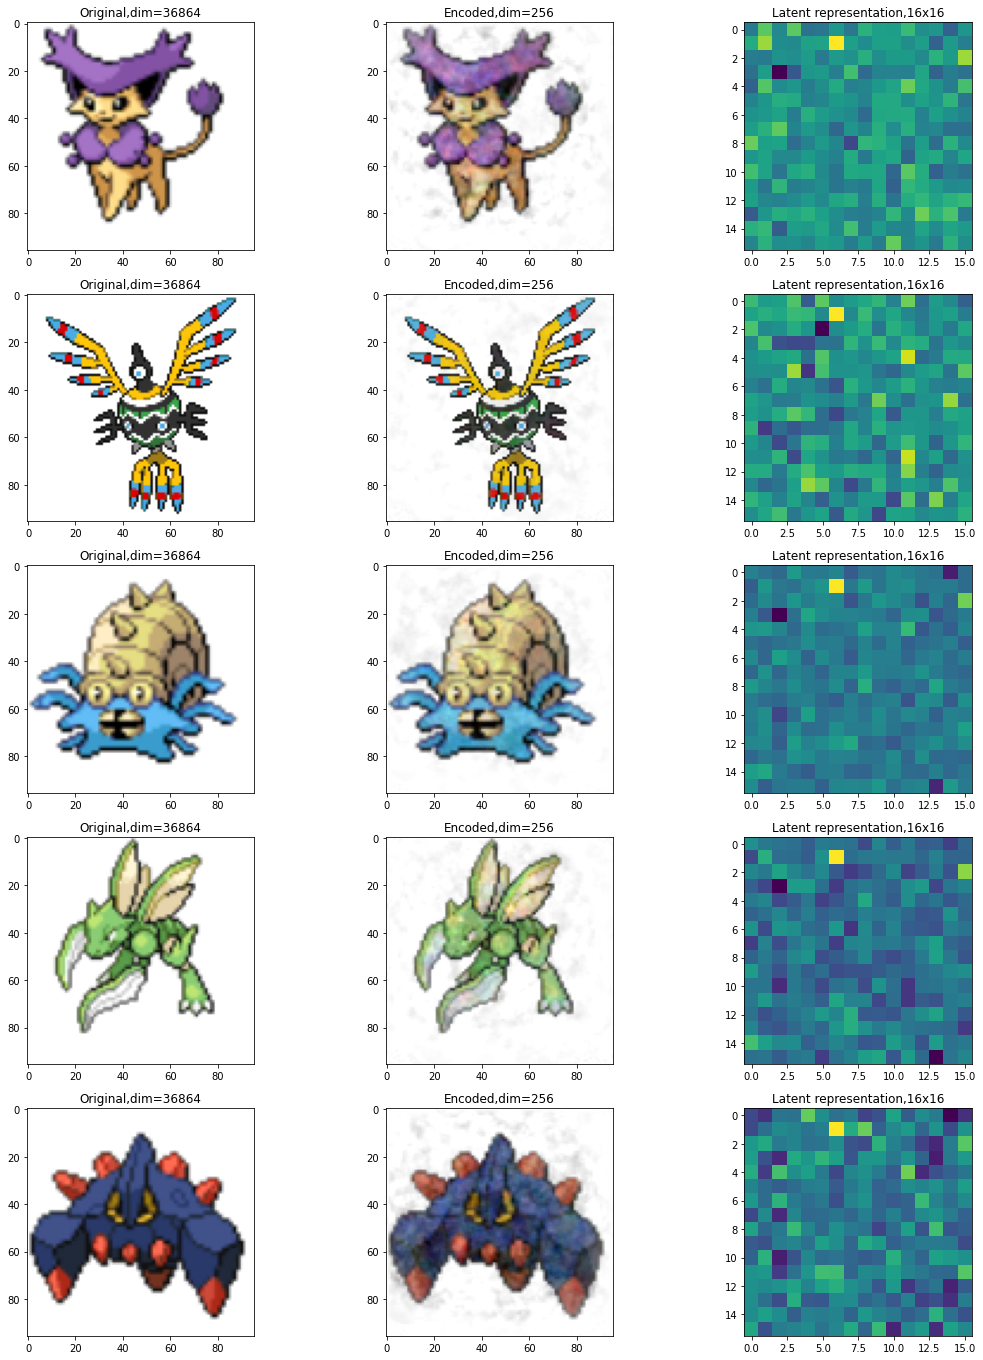

In [83]:

def result(idx):
  image_path=os.path.join(dir,files_[idx])
  image=io.imread(image_path)
  img=transforms.ToTensor()(image)
  tmp=model(img.flatten().to(device)).cpu()
  encoded_data=model.encoder(img.flatten().to(device)).cpu()
  tmp = tmp.reshape(img.shape)
  tmp = tmp.permute(1, 2, 0)
  tmp = tmp.detach().numpy()
  img = img.permute(1, 2, 0)
  img = img.detach().numpy()
  encoded_data = encoded_data.detach().numpy()
  return img,tmp,encoded_data



rows=5 #number of samples
f, axs = plt.subplots(rows, 3, figsize=(16, 19))
for i in range(rows):
  idx=random.randint(0,len(files_))
  print(idx)
  img, img_recon, latent_representation=result(idx)
  axs[i,0].imshow(img)
  axs[i, 0].set_title(f'Original,dim={size*size*4}')
  axs[i,1].imshow(img_recon)
  axs[i, 1].set_title(f'Encoded,dim={input_layer_size//4}')
  axs[i,2].imshow(latent_representation.reshape(16,16))
  axs[i, 2].set_title(f'Latent representation,{16}x{16}')  
plt.tight_layout();

In [56]:
#log checkpoint to drive
torch.save(model.state_dict(), save_file)

**Image generation**

In the generative part of this project we'll use a DC-GAN Taking as input the latent representation (reshaped to 16x16) outputed by the encoder.